# Модель-пример

#### Импорт необходимых библиотек

In [1]:
import sys
import numpy as np
from PIL import Image
import tensorflow as tf
import tensorflow_addons as tfa
import torchvision as tv
import matplotlib.pyplot as plt
from livelossplot import PlotLossesKeras

sys.path.append('../../')

from core.datasets import get_ds
from core.make_answer import make_ans_file

c:\Users\Mi\Desktop\ML\.conda\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


#### Формируем аугментацию.

##### Вариант 1.

- Пишите аугментацию. Объект класса tv.transforms.Compose или tv.transforms.{аугментация}

In [2]:
transformer = tv.transforms.Compose([
    tv.transforms.RandomAdjustSharpness(sharpness_factor=5, p=.4),
    tv.transforms.RandomHorizontalFlip(p=.5),
    tv.transforms.RandomPosterize(bits=3, p=.3),
    tv.transforms.RandomPerspective(distortion_scale=0.2, p=.5),
    tv.transforms.RandomRotation(degrees=(-10, 10)),
    tv.transforms.ColorJitter(brightness=.2, hue=0.2),
])

##### Вариант 2. (Лиза добавила крутую возможность)
- Пишите несколько агументаций как из варианта два
- Все их записываете в список

Получается так, что для каждого изображения применяется рандомный вариант аугментации, из вами написанных.

Зачем это сделано: Есть некоторые варианты агументации, в которых нет параметра вероятности. Получается так, что Grayscale делает весь трейновый датасет черно-белым, а валидационный и тестовый все такие же разноцветные. То есть в этом случае мы модель не знает, что картинки разноцветные.

`Про варианты агументации и подбор параметров написано в notebooks/skewbek/Augmentation. Всем ознакомиться. (Можно просто делать копипаст комбинаций оттуда)`

In [3]:
transformer1 = tv.transforms.Compose([
    tv.transforms.RandomInvert(p=0.4),
    tv.transforms.RandomPerspective(distortion_scale=0.2, p=0.4),
])
transformer2 = tv.transforms.Compose([
    tv.transforms.RandomPosterize(bits=6, p=0.4),
    tv.transforms.ColorJitter(brightness=.2, hue=0.2, contrast=0.5),
    tv.transforms.RandomAffine(degrees=(-15, 15), translate=(0, 0.1), scale=(0.85, 1)),
])
transformer3 = tv.transforms.Compose([
    tv.transforms.ColorJitter(brightness=.2, hue=0.2, contrast=0.5),
    tv.transforms.RandomAffine(degrees=(-15, 15), translate=(0, 0.1), scale=(0.85, 1)),
    tv.transforms.RandomPerspective(distortion_scale=0.2, p=0.4),
])
transformer = [transformer1, transformer2, transformer3]

#### Создаем датасеты
```python
get_ds(
    file_train, `Путь к трейновому датасету`
    file_test, `Путь к тестовому датасету`
    transform=None,  `Аугументация`
    batch_size=512,  `Размер батча`
    one_hot=False,  `Формат ответов one_hot_encoding или нет`
    val_size=0.03,  `Размер валидационного датасета, относительно data_train`
    back=1,  `На сколько уровней в директории надо подняться наверх, чтобы дойти до корневой`
)
```

Позже мы будем ансамбли и похожие эвристики, поэтому всегда делайте `one_hot=True`

In [4]:
train_ds, val_ds, test_ds = get_ds('repaired_data_train', 'repaired_data_test', transform=transformer, one_hot=True, back=2)

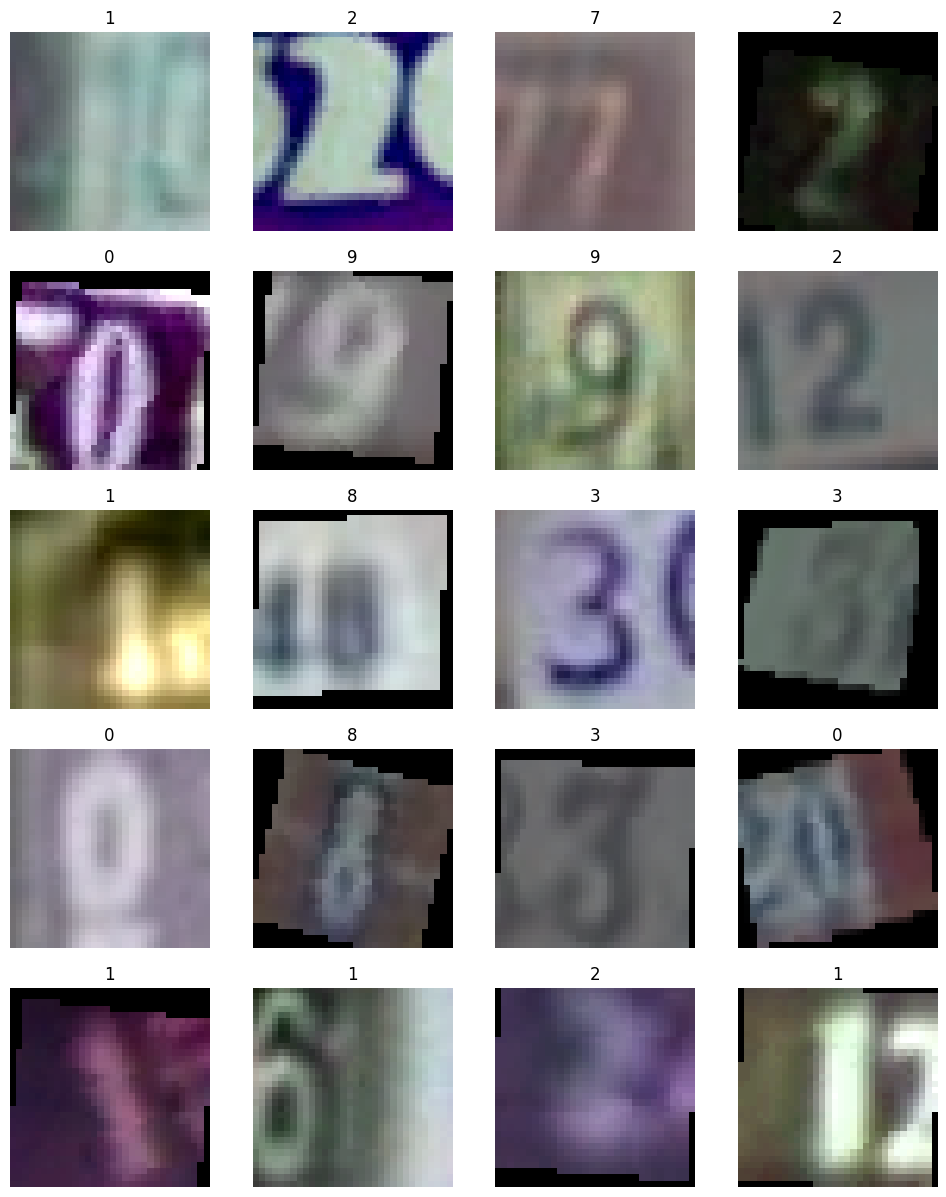

In [5]:
plt.figure(figsize=(12, 15))
train_ds_visualization = train_ds[0]
for i in range(20):
    plt.subplot(5, 4, i + 1)
    img = np.array(Image.fromarray((train_ds_visualization[0][i] * 255).astype(np.uint8), 'RGB'))
    plt.imshow(img / 255, cmap=plt.cm.binary)
    plt.title(np.argmax(train_ds_visualization[1][i]))
    plt.axis('off')
plt.show()

#### Пишем модель
Для правильного использования ансамблирования, в финальном слое не пишем функцию активации. Подробнее написано у Дениса.

In [10]:
model_1 = tf.keras.Sequential([
    tf.keras.Input(shape=(32, 32, 3), batch_size=512),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.AveragePooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.AveragePooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0,2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10),
])
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (512, 30, 30, 32)         896       
                                                                 
 conv2d_4 (Conv2D)           (512, 28, 28, 64)         18496     
                                                                 
 batch_normalization_1 (Batc  (512, 28, 28, 64)        256       
 hNormalization)                                                 
                                                                 
 average_pooling2d_2 (Averag  (512, 14, 14, 64)        0         
 ePooling2D)                                                     
                                                                 
 conv2d_5 (Conv2D)           (512, 12, 12, 128)        73856     
                                                                 
 average_pooling2d_3 (Averag  (512, 6, 6, 128)        

#### Создаем чекпоинты (всем уже рассказал)
- Если лень, то просто копипаст того, что я написал ниже. НЕ ЗАБЫВАЕМ МЕНЯТЬ ПЕРЕМЕННУЮ `num_model`!!!

In [7]:
metrics = ['categorical_accuracy',
           tfa.metrics.F1Score(num_classes=10, average='macro', name='f1_score')]
num_model = 1
callbacks = [
    PlotLossesKeras(),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=f'../checkpoints/model{num_model}_categorical_accuracy.h5',
        monitor='val_categorical_accuracy',
        mode='max',
        save_best_only=True,
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=f'../checkpoints/model{num_model}_loss.h5',
        monitor='val_loss',
        mode='min',
        save_best_only=True,
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=f'../checkpoints/model{num_model}_f1_score.h5',
        monitor='val_f1_score',
        mode='max',
        save_best_only=True,
    ),
]


#### Компиляция модели
- Если будете что то менять, то только оптимизатор. Про оптимизаторы написано у Лизы.

In [8]:
model_1.compile(
    optimizer='adam', metrics=metrics,
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
)

Обучаем модель

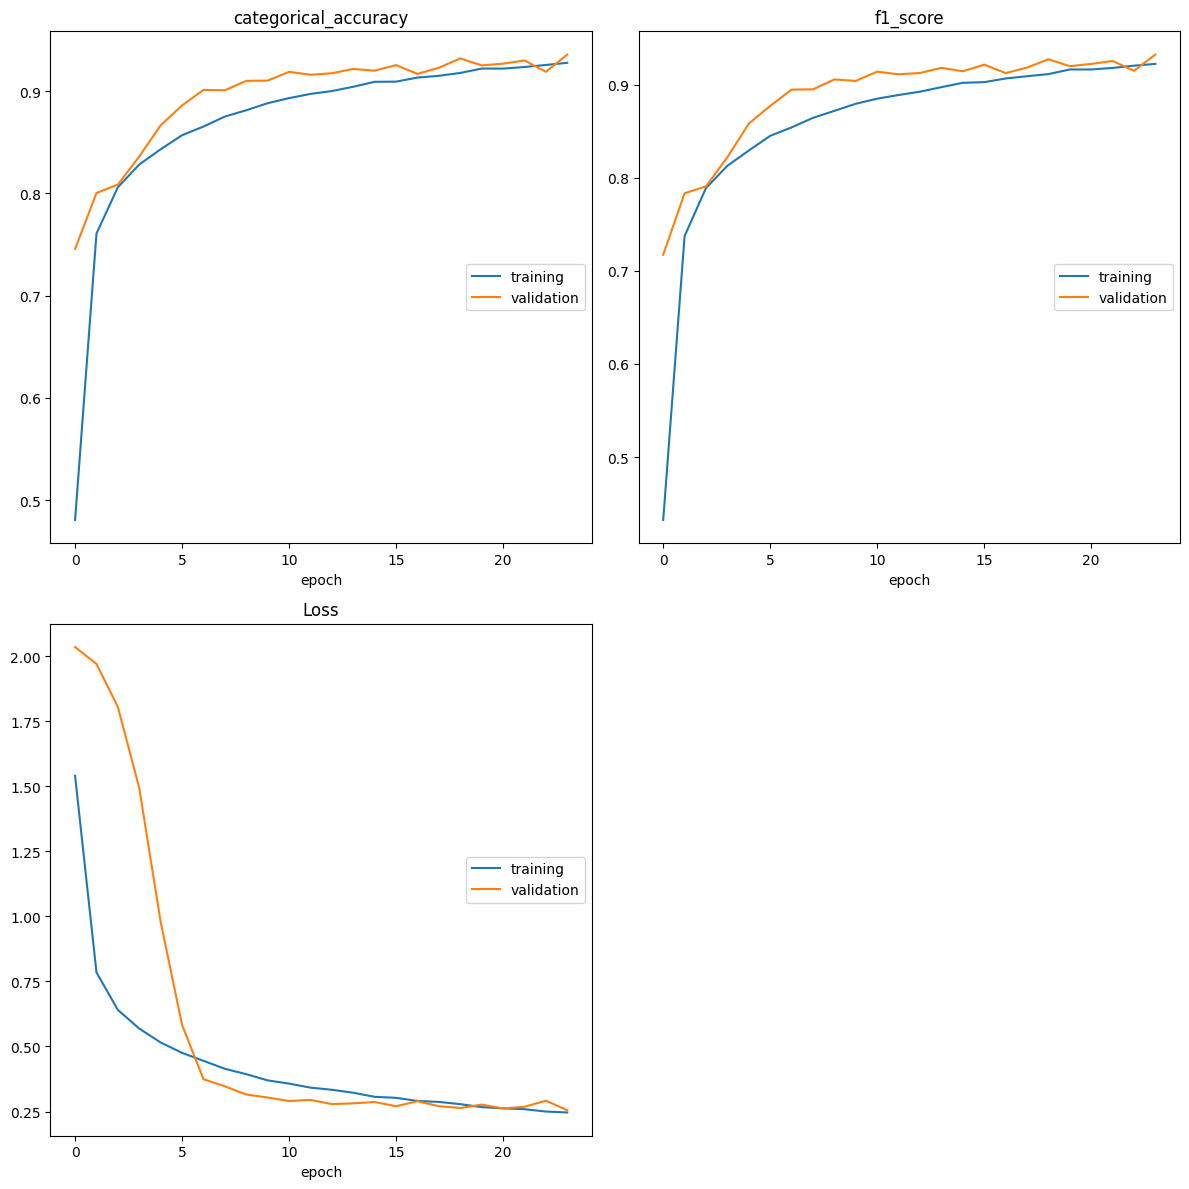

categorical_accuracy
	training         	 (min:    0.481, max:    0.928, cur:    0.928)
	validation       	 (min:    0.746, max:    0.936, cur:    0.936)
f1_score
	training         	 (min:    0.432, max:    0.922, cur:    0.922)
	validation       	 (min:    0.717, max:    0.932, cur:    0.932)
Loss
	training         	 (min:    0.247, max:    1.540, cur:    0.247)
	validation       	 (min:    0.255, max:    2.035, cur:    0.255)


KeyboardInterrupt: 

In [9]:
model_1.fit(train_ds, validation_data=val_ds,
            epochs=100, callbacks=callbacks, verbose=False)

Подгружаем все чекпоинты

In [ ]:
model_categorical_acc = tf.keras.models.load_model(f'../checkpoints/model{num_model}_categorical_accuracy.h5')
model_f1_score = tf.keras.models.load_model(f'../checkpoints/model{num_model}_f1_score.h5')
model_loss = tf.keras.models.load_model(f'../checkpoints/model{num_model}_loss.h5')

У нас поличилось три чекпоинта (три модели). Ниже указан код для сохрания ответов для модели на каждой эпохе.

In [ ]:
ans_categorical_accuracy = make_ans_file(f'../answers/model{num_model}_categorical_accuracy.csv', model_categorical_acc)
ans_f1_score = make_ans_file(f'../answers/model{num_model}_f1_score.csv', model_f1_score)
ans_loss = make_ans_file(f'../answers/model{num_model}_loss.csv', model_loss)

- Позже допишу код с проверкой на то, что эти чекпоинты не из одной эпохи.

- Денис пишет ансамблинг моделей. Когда он допишет, мы применим это для формирования ответа по трем получившимся моделям.

В конце смотрим на метрики и делаем выводы о том, чем хороша эта модель. Какие классы она угадывает лучше/худше всего. Дописываем какую метрику показал kaggle.

In [ ]:
class MulticlassClassificationMetrics:
    def __init__(self, y_true, y_pred):
        self.y_true = np.array(y_true)
        self.y_pred = np.array(y_pred)
        self.matrix_error = self.get_matrix_error()

    def get_matrix_error(self):
        self.class_types = np.unique([self.y_true, self.y_pred])
        TP, FN, FP, TN = [], [], [], []
        for class_type in self.class_types:
            TP.append(np.sum(np.logical_and(
                self.y_true == self.y_pred,
                self.y_true == class_type,
            )))
            FN.append(np.sum(np.logical_and(
                self.y_true == class_type,
                self.y_pred != class_type,
            )))
            FP.append(np.sum(np.logical_and(
                self.y_pred == class_type,
                self.y_true != class_type,
            )))
            TN.append(np.sum(np.logical_and(
                self.y_pred != class_type,
                self.y_true != class_type,
            )))
        return pd.DataFrame({
            'class_type': self.class_types,
            'TP': TP, 'TN': TN, 'FP': FP, 'FN': FN,
        }).set_index('class_type')

    def accuracy(self):
        return np.sum(self.y_true == self.y_pred) / self.y_true.shape[0]

    def precision(self, averaging='macro'):
        if averaging == 'macro':
            precisions = self.matrix_error['TP'] / (self.matrix_error['TP'] + self.matrix_error['FP'])
            return np.mean(precisions.replace(np.nan, 0))
        elif averaging == 'micro':
            mean_val = self.matrix_error.mean()
            return mean_val['TP'] / (mean_val['TP'] + mean_val['FP'])

    def recall(self, averaging='macro'):
        if averaging == 'macro':
            recalls = self.matrix_error['TP'] / (self.matrix_error['TP'] + self.matrix_error['FN'])
            return np.mean(recalls.replace(np.nan, 0))
        elif averaging == 'micro':
            mean_val = self.matrix_error.mean()
            return mean_val['TP'] / (mean_val['TP'] + mean_val['FN'])

    def f1_score(self, averaging='macro'):
        if averaging == 'macro':
            reverse_r = (self.matrix_error['TP'] + self.matrix_error['FN']) / self.matrix_error['TP']
            reverse_p = (self.matrix_error['TP'] + self.matrix_error['FP']) / self.matrix_error['TP']
            f1_scores = 2 / (reverse_r + reverse_p)
            return np.mean(f1_scores.replace(np.nan, 0))
        elif averaging == 'micro':
            p = self.precision(averaging)
            r = self.recall(averaging)
            return 2 * p * r / (p + r)

    def metrics(self, averaging='macro'):
        return {
            'accuracy': self.accuracy(),
            'precision': self.precision(averaging),
            'recall': self.recall(averaging),
            'f1_score': self.f1_score(averaging),
        }

    def __str__(self):
        headers = {
            'selector': '*',
            'props': 'background-color: darkgreen; color: white; font-size: 12pt;',
        }
        che_super_mega_puper_visualization_of_cell = { 
            'selector': 'td:hover',
            'props': 'background-color: green; color: white;',
        }
        display(
            self.matrix_error
            .style
            .set_table_styles([
                headers,
                che_super_mega_puper_visualization_of_cell,
            ])
            .set_properties(**{'background-color': 'lightgreen',
                           'color': 'black', 'font-size': '12pt'})
        )
        return ''

    def __repr__(self):
        return (
            f'MulticlassClassificationMetrics(class_types={self.class_types})'
            .replace("'", '').replace(',', ';'))